In [1]:
# Import libraries
import numpy as np
import pandas as pd

# local imports
import config
import util
from util import clean_data
from util import write_regr_eval

# random state
import os
import sys
import random
import numpy as np
SEED=config.SEED
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

# machine learning
import functools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# boosting
import catboost as cb

In [2]:
data_path_train = '../data/raw/train.csv'
data_path_test = '../data/raw/test.csv'
target = config.target
logtarget = True

params_data = dict(
    log=True,
    sq=True,
    logsq=False,
    dummy=True,
    dummy_cat=False)

params_cb = config.params_cb
model_cb_dump = '../models/model_cb.dump'

In [14]:
#=================== load the data
df_train = pd.read_csv(data_path_train)
df_test = pd.read_csv(data_path_test)

df_train = clean_data(df_train,**params_data)
df_test = clean_data(df_test,**params_data)

#======================== feature selection
features = list(sorted(df_train.columns.drop(target)))
features = [i for i in features if i in df_test.columns]


df_Xtrain = df_train[features]
df_Xtest = df_test[features]
ytrain = np.array(df_train[target]).flatten()

if logtarget:
    ytrain = np.log1p(ytrain)

In [4]:
%%time

## We don't need to train more than once for deploying the model
if os.path.exists(model_cb_dump):
    os.remove(model_cb_dump)
    
model = cb.CatBoostRegressor(**params_cb)
model.fit(df_Xtrain,ytrain)
model.save_model(model_cb_dump)

CPU times: user 16.3 s, sys: 642 ms, total: 16.9 s
Wall time: 5.02 s


# Predictions

In [7]:
model = cb.CatBoostRegressor()
model = model.load_model(model_cb_dump)

ypreds = model.predict(df_test[features])
ypreds = ypreds.flatten()
if logtarget:
    ypreds = np.expm1(ypreds)
    

ypreds

array([317520.05086988, 221473.59319332, 513032.95014102, ...,
       799170.86521365, 381259.74185433, 762112.47986158])

In [8]:
util.print_regr_eval(df_test[target],ypreds,ncols=len(features))

ytest : [285000. 239950. 460000.]
ypreds: [317520.05086988 221473.59319332 513032.95014102]

Explained Variance: 0.912510

         R-Squared: 0.911658

             RMSE : 109,113.67

Adjusted R-squared: 0.910414



'\nExplained Variance: 0.912510\n\n         R-Squared: 0.911658\n\n             RMSE : 109,113.67\n\nAdjusted R-squared: 0.910414\n'

In [11]:
ar2 = 1.04
ncols = 20
ytest = 10
if ar2 > 1.0:
    warn = "WARNING: Here, adjusted R-squared value if more than 1."+\
        "Please check if number of predictors (p) is more than "+\
        "sample size (N) i.e. p >= N"+\
        "p = {}".format(ncols)+\
        "N = {}".format(20)

    print(warn)

# Model Explanation

In [15]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_Xtest)
expected_value = explainer.expected_value

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


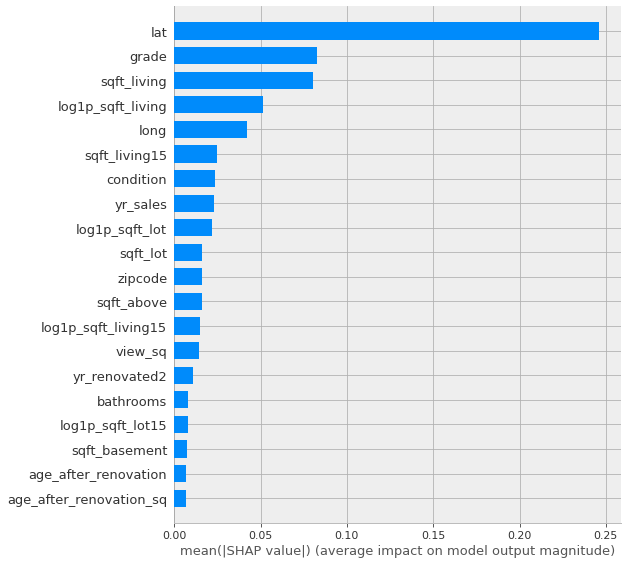

In [17]:
shap.summary_plot(shap_values, df_Xtest, plot_type='bar')

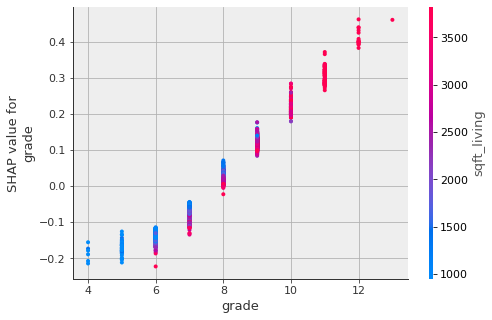

In [16]:
shap.dependence_plot("rank(1)", shap_values, df_Xtest)

In [21]:
# shap.dependence_plot?